### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(12, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "L"

In [7]:
df_L = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "L"].copy()
df_L

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,2024-08-31,IMELDA,SUMBER JAYA TIMUR,SEPASO BARAT,BENGALON,PEREMPUAN,2004-07-20,MAHASISWA/PELAJAR,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,LP3,L,INDIVIDU,20
6849,2024-08-31,HANIF IHABULLAH IFTIKHAR,JL PENEGAK,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,2005-04-01,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTA/SMU,LVE,L,INDIVIDU,20
6850,2024-08-31,FAHREL SAJDAH RIFQIYA LEMAN,JL. MARSMA R ISWAHYUDI,SEPINGGAN RAYA,BALIKPAPAN SELATAN,LAKI-LAKI,1973-03-21,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,LV1,L,INDIVIDU,52
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64


Plot data initial varian plus "L"

In [8]:
df_L_count = df_L[["Tgl. Mohon"]].copy()
df_L_count["count"] = 1.
df_L_count = df_L_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_L_count["cumulative_sum"] = df_L_count["count"].cumsum()
df_L_count["rolling_7days"] = df_L_count["count"].rolling(window=7, min_periods=1).sum()
df_L_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2021-01-02,5,5,5.0
1,2021-01-04,2,7,7.0
2,2021-01-05,3,10,10.0
3,2021-01-06,4,14,14.0
4,2021-01-07,7,21,21.0
...,...,...,...,...
1064,2024-08-27,2,5118,24.0
1065,2024-08-28,1,5119,20.0
1066,2024-08-29,3,5122,20.0
1067,2024-08-30,2,5124,17.0


Groub by weekly

In [9]:
df_L_weekly = df_L_count[["Tgl. Mohon"]].copy()
df_L_count["Tgl. Mohon"] = pd.to_datetime(df_L_count["Tgl. Mohon"])

df_L_weekly = (df_L.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_L_weekly["cumulative_sum"] = df_L_weekly["count"].cumsum()
df_L_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,7,7
1,2021-01-11,26,33
2,2021-01-18,10,43
3,2021-01-25,19,62
4,2021-02-01,11,73
...,...,...,...
187,2024-08-05,22,5050
188,2024-08-12,19,5069
189,2024-08-19,25,5094
190,2024-08-26,22,5116


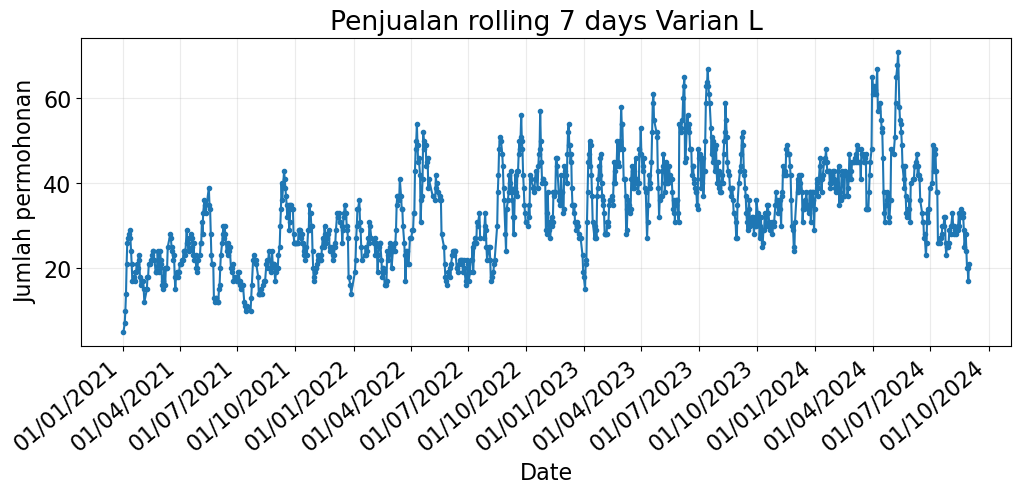

In [10]:
plot_time_series(df_L_count["Tgl. Mohon"], df_L_count["rolling_7days"], 
                title="Penjualan rolling 7 days Varian L",
                xlabel="Date", ylabel="Jumlah permohonan")

In [11]:
Q1 = df_L_count["rolling_7days"].quantile(0.25)
Q3 = df_L_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_L_count[(df_L_count["rolling_7days"] < batas_bawah) | 
                      (df_L_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian L: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian L: 4


,Tgl. Mohon,count,cumulative_sum,rolling_7days
733,2023-07-15,11,3281,67.0
958,2024-04-08,15,4569,67.0
980,2024-05-10,8,4712,68.0
981,2024-05-11,9,4721,71.0


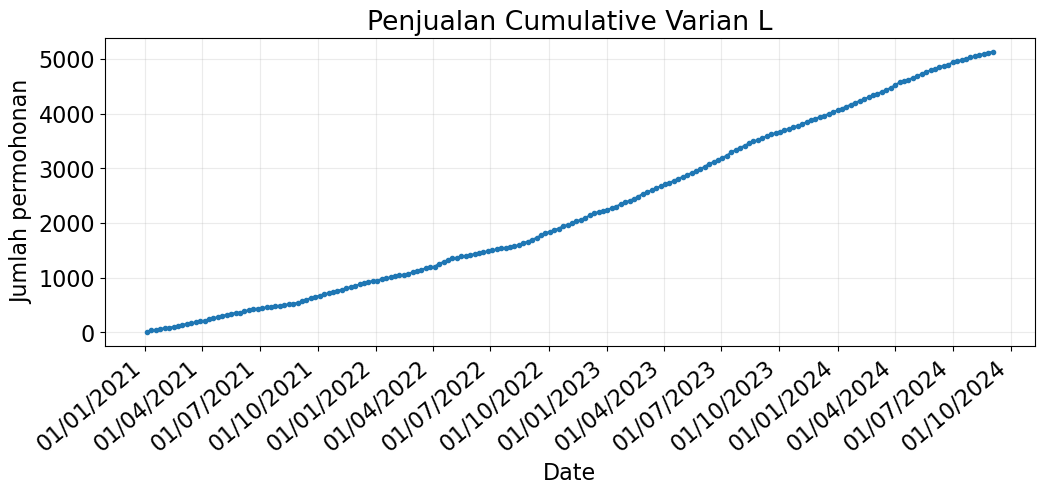

In [12]:
plot_time_series(df_L_weekly["Tgl. Mohon"], df_L_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian L",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [13]:
ADF_result = adfuller(df_L_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 1.0000418373745945
p-value: 0.9942663899610118


first diff (_d_=1)

In [14]:
L_diff_week = np.diff(df_L_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(L_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.6830863053482834
p-value: 0.07701108524681861


sec diff (_d_=2)

In [15]:
L_diff2 = np.diff(L_diff_week, n=1)
ADF_result2 = adfuller(L_diff2)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")

ADF statistic : -11.423106568361865
p-value : 6.797386726765058e-21


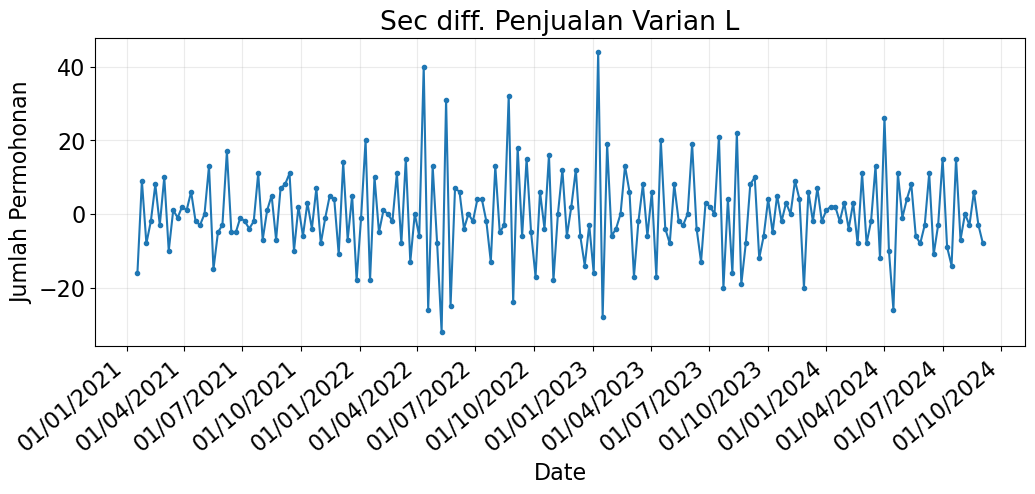

In [16]:
plot_time_series(df_L_weekly["Tgl. Mohon"].iloc[2:], L_diff2, 
                 title="Sec diff. Penjualan Varian L",
                 xlabel="Date", ylabel="Jumlah Permohonan")

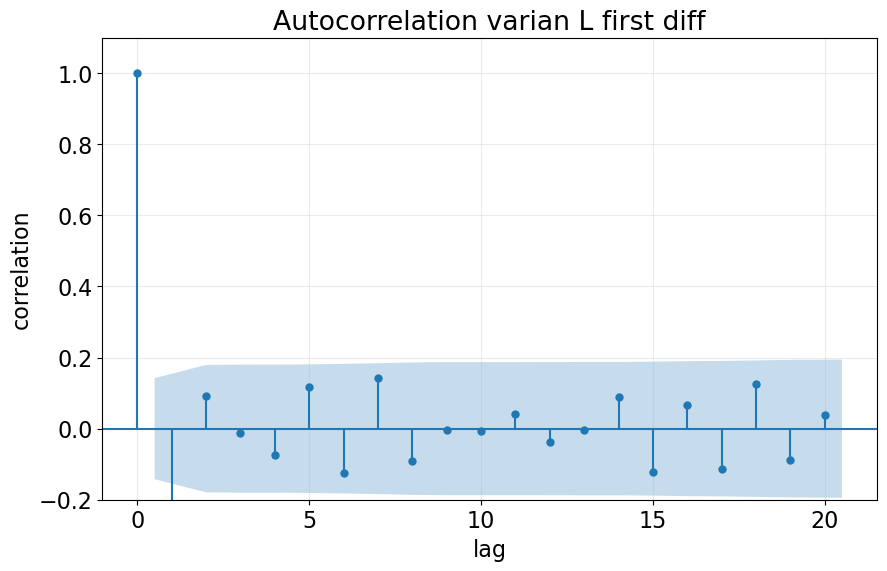

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

fig = plot_acf(L_diff2, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian L first diff")
ax.grid("on")

plt.show(fig)

#### harian

In [18]:
ADF_result = adfuller(df_L_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 4.704547484746637
p-value: 1.0


fisrt diff (_d_=1)

In [19]:
L_diff = np.diff(df_L_count["cumulative_sum"], n=1)
ADF_result = adfuller(L_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -3.075095604463298
p-value: 0.028451968450453325


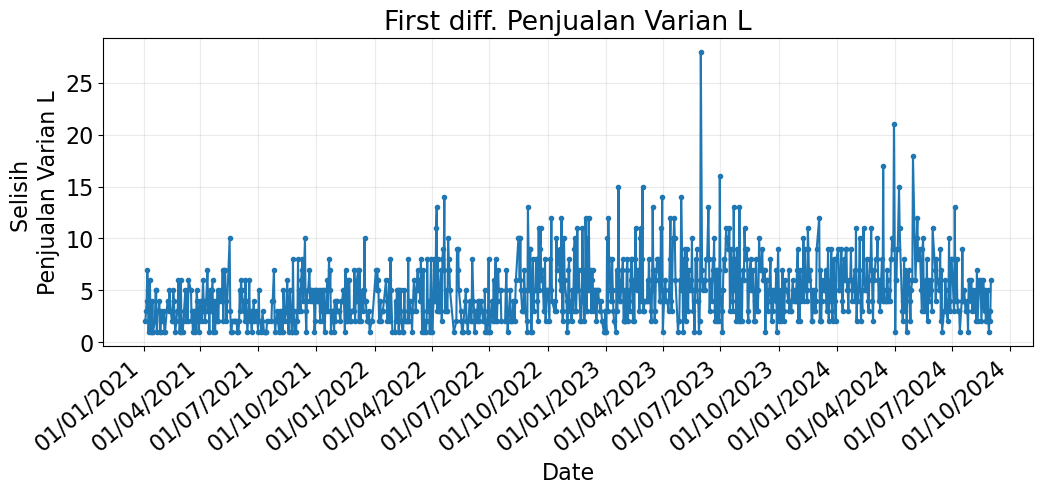

In [20]:
plot_time_series(df_L_count["Tgl. Mohon"].iloc[1:], L_diff, 
                 title="First diff. Penjualan Varian L",
                 xlabel="Date", ylabel="Selisih \nPenjualan Varian L")

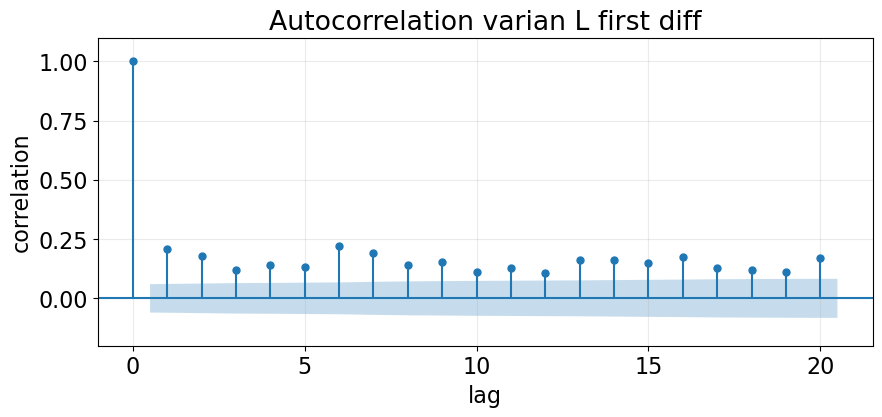

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(L_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian L first diff")
ax.grid("on")

plt.show(fig)

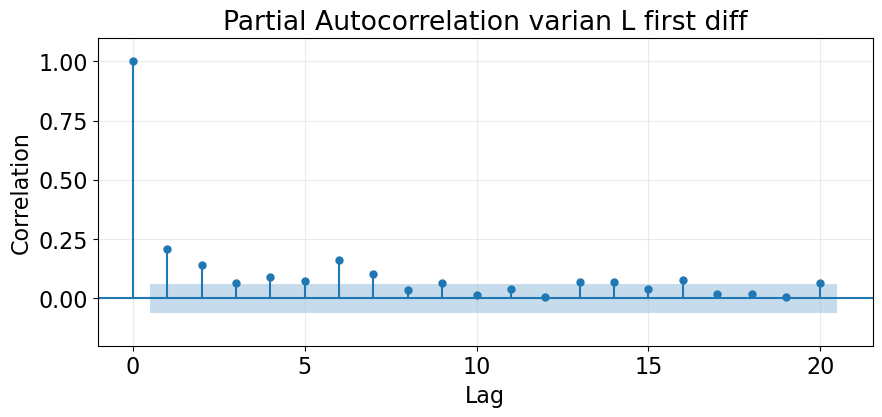

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(L_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian L first diff")
ax.grid("on")

plt.show()

In [23]:
advanced_decomposition = STL(df_L_count["cumulative_sum"], period=12).fit()
advanced_decomposition

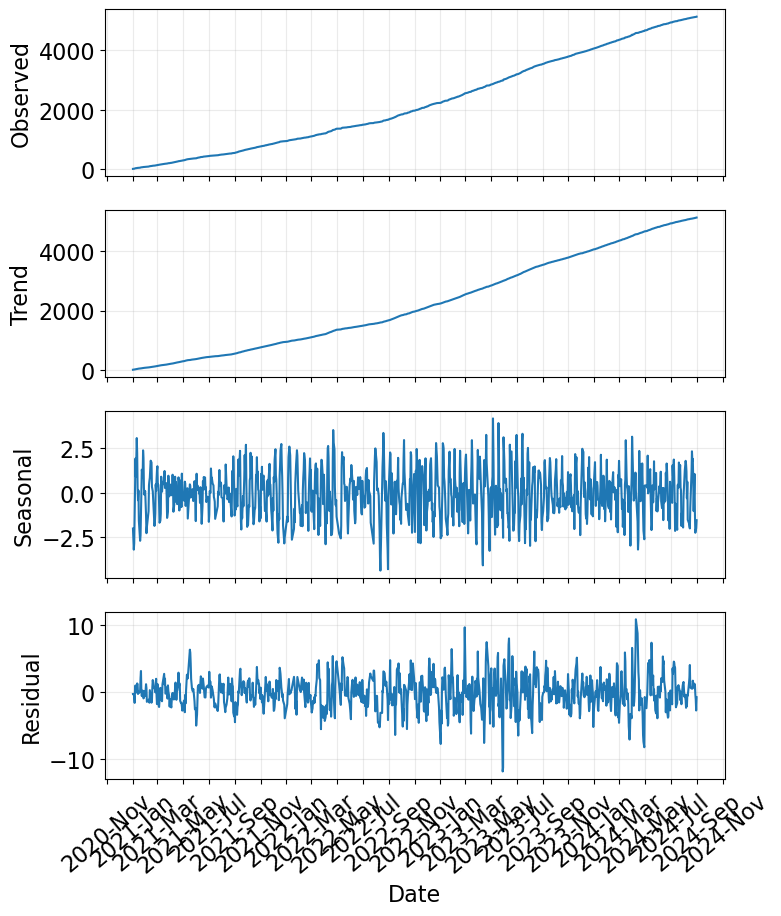

In [24]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

axes[0].plot(df_L_count["Tgl. Mohon"], advanced_decomposition.observed)
axes[1].plot(df_L_count["Tgl. Mohon"], advanced_decomposition.trend)
axes[2].plot(df_L_count["Tgl. Mohon"], advanced_decomposition.seasonal)
axes[3].plot(df_L_count["Tgl. Mohon"], advanced_decomposition.resid)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].xaxis.set_major_locator(locator)

for label in axes[3].get_xticklabels():
  label.set_rotation(40)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

### Data Splitting

In [25]:
split_idx = int(0.8 * len(df_L_count))
df_train = df_L_count.iloc[:split_idx].copy()
df_test = df_L_count.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (855, 214)


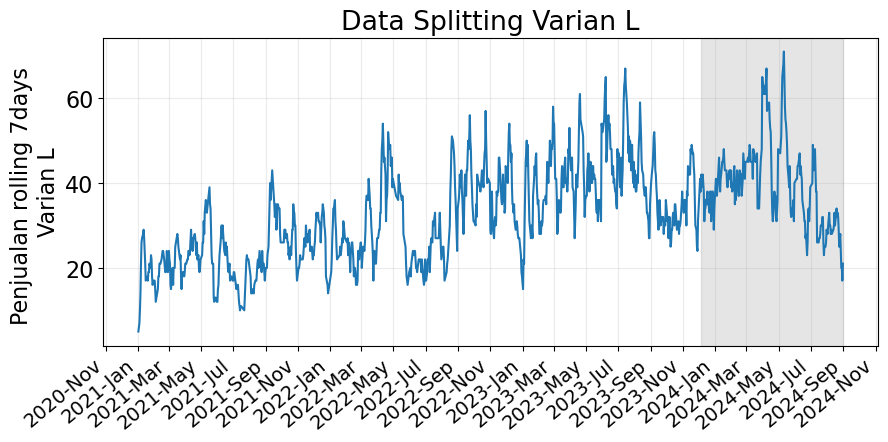

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_L_count['Tgl. Mohon'], df_L_count["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan rolling 7days \nVarian L")
ax.set_title("Data Splitting Varian L")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (1,1,2)

In [27]:
p_space = range(0, 13, 1)  # set 0 to 13 to capture seasonal information
q_space = range(0, 13, 1)
P_space = [0]   # set P and Q to 0 because we are working with ARIMA(p,d,q)
Q_space = [0]

d = 1
D = 0   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

arima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(arima_order_list)}")
arima_order_list

num. of possible paramters setting: 169


[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

In [28]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [29]:
# Computational time: 8m 48.1s
# arima_result_df = optimize_SARIMA(df_train["rolling_7days"], arima_order_list, d,
#                            D, m, enforce_invertibility=True, enforce_stationarity=True)

In [30]:
# arima_result_df.to_csv("./data/varian-l-arima-result.csv", index=False)

In [31]:
reload_arima_result_df = pd.read_csv("./data/varian-l-arima-result.csv")
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(1, 7, 0, 0)",4167.715953
1,"(0, 8, 0, 0)",4168.151123
2,"(0, 9, 0, 0)",4169.518006
3,"(2, 7, 0, 0)",4170.217632
4,"(1, 9, 0, 0)",4170.430424
...,...,...
164,"(5, 0, 0, 0)",4663.988470
165,"(4, 1, 0, 0)",4664.440228
166,"(3, 2, 0, 0)",4664.441529
167,"(6, 0, 0, 0)",4665.819904


In [32]:
# arima_result_df
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(1, 7, 0, 0)",4167.715953
1,"(0, 8, 0, 0)",4168.151123
2,"(0, 9, 0, 0)",4169.518006
3,"(2, 7, 0, 0)",4170.217632
4,"(1, 9, 0, 0)",4170.430424
...,...,...
164,"(5, 0, 0, 0)",4663.988470
165,"(4, 1, 0, 0)",4664.440228
166,"(3, 2, 0, 0)",4664.441529
167,"(6, 0, 0, 0)",4665.819904


In [33]:
# best_pqPQ = reload_arima_result_df["(p,q,P,Q)"].iloc[1]
# best_arima_p, best_arima_q, _, _ = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

In [34]:
best_arima_p, best_arima_q \
  = (1, 7)
print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

best ARIMA (p,q): (1, 7)


In [35]:
model_arima_best = SARIMAX(df_train["rolling_7days"], order=(best_arima_p, d, best_arima_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


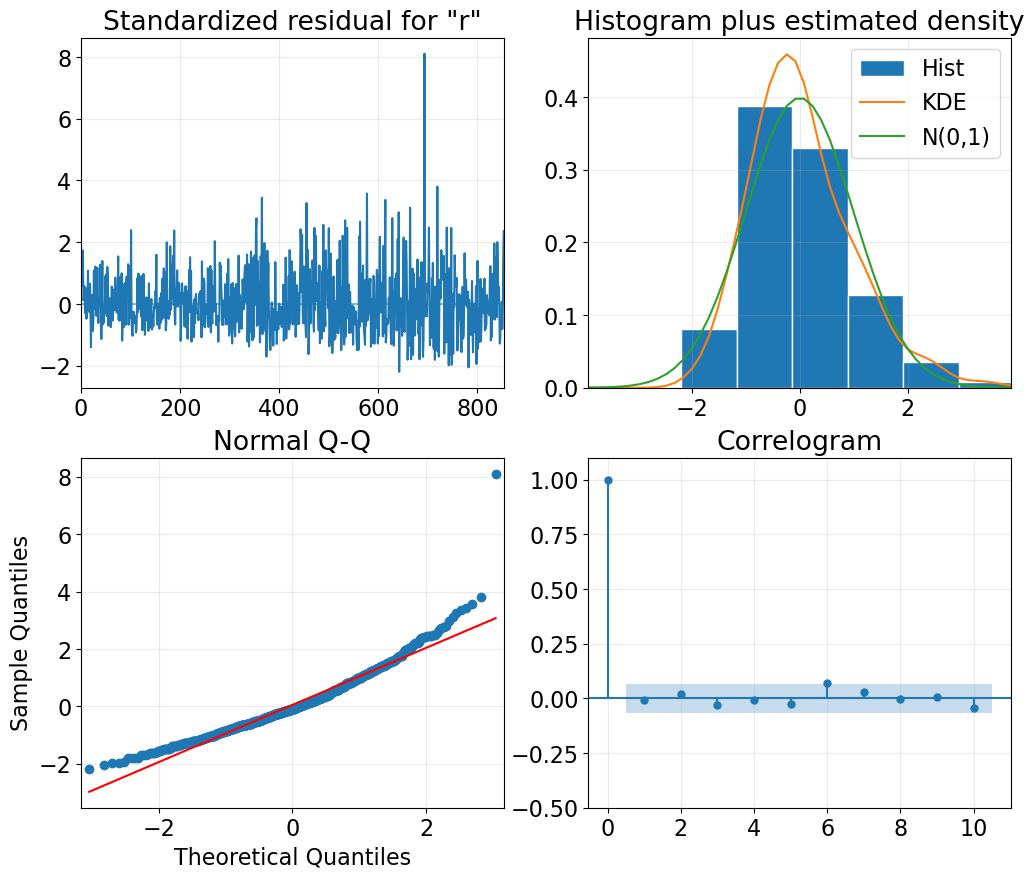

In [36]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [37]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.010443,0.918607
2,0.611276,0.736653
3,1.143450,0.766597
4,1.144042,0.887223
5,1.540936,0.908298
6,5.753501,0.451362
7,6.603514,0.471294
8,6.618793,0.578263
9,6.624771,0.676121
10,8.084528,0.620581


- Pada lag 1 dan 2 nilai p-value lebih besar dari 0.05, maka kita tidak reject the null hypothesis pada  lag tersebut.
- Artinya residual bersifat independen dan tidak berkorelasi, sehingga residual dari model ARIMA dianggap sebagai white noise dan model sudah cukup baik dalam menangkap pola data.

In [38]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

pred_mean = df_train["rolling_7days"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_mean"] = pred_mean
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_arima
855,2023-12-05,2,3938,38.0,47.0,42.689364
856,2023-12-06,7,3945,42.0,53.0,45.032883
857,2023-12-07,2,3947,39.0,47.0,45.269066
858,2023-12-08,4,3951,40.0,43.0,47.653535
859,2023-12-09,6,3957,42.0,44.0,48.762940


### SARIMA

In [39]:
p_space = range(0, 4, 1)  
q_space = range(0, 4, 1)
P_space = range(0, 4, 1)   
Q_space = range(0, 4, 1)

d = 1
D = 1   
m = 12

sarima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarima_order_list)}")
sarima_order_list

num. of possible paramters setting: 256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [40]:
# Computational time: 47m 9.8s
# sarima_result_df = optimize_SARIMA(df_train["rolling_7days"], sarima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [41]:
# sarima_result_df.to_csv("./data/varian-l-sarima-result.csv", index=False)

In [42]:
reload_sarima_result_df = pd.read_csv("./data/varian-l-sarima-result.csv")
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 0, 3)",18.000000
1,"(3, 3, 0, 1)",4482.760068
2,"(3, 3, 0, 3)",4487.857845
3,"(3, 3, 1, 3)",4489.077260
4,"(3, 3, 0, 2)",4492.018738
...,...,...
250,"(0, 3, 0, 0)",5172.512054
251,"(3, 0, 0, 0)",5172.735434
252,"(1, 3, 0, 0)",5174.488720
253,"(3, 1, 0, 0)",5174.736967


In [43]:
# sarima_result_df
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 0, 3)",18.000000
1,"(3, 3, 0, 1)",4482.760068
2,"(3, 3, 0, 3)",4487.857845
3,"(3, 3, 1, 3)",4489.077260
4,"(3, 3, 0, 2)",4492.018738
...,...,...
250,"(0, 3, 0, 0)",5172.512054
251,"(3, 0, 0, 0)",5172.735434
252,"(1, 3, 0, 0)",5174.488720
253,"(3, 1, 0, 0)",5174.736967


In [44]:
# best_pqPQ = reload_sarima_result_df["(p,q,P,Q)"].iloc[0]
# best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
#   = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

In [45]:
best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
  = (3, 3, 1, 3)
print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

best SARIMA (p,q,P,Q): (3, 3, 1, 3)


In [46]:
model_sarima_best = SARIMAX(df_train["rolling_7days"], order=(best_sarima_p, d, best_sarima_q), 
                            seasonal_order=(best_sarima_P, D, best_sarima_Q, m),
                            simple_differencing=False)
model_sarima_best_fit = model_sarima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


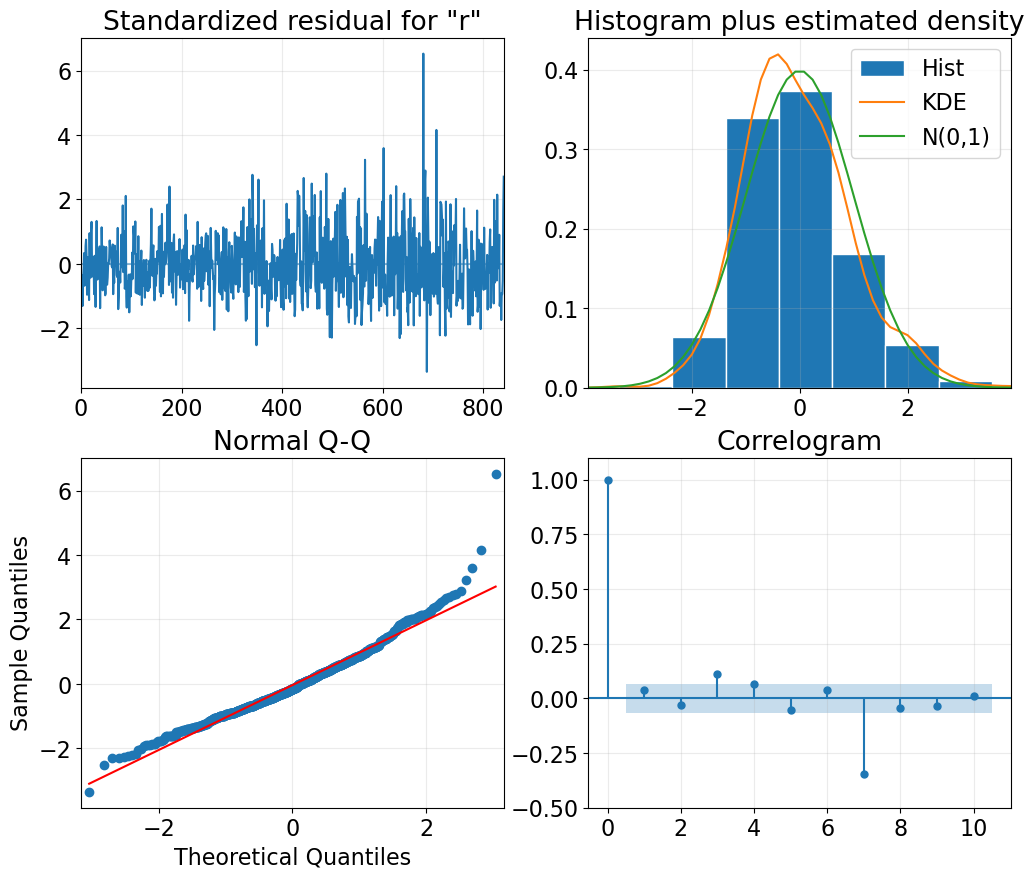

In [47]:
fig = model_sarima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [48]:
residuals = model_sarima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,2.357604,1.246736e-01
2,2.575075,2.759495e-01
3,14.998128,1.818249e-03
4,19.873825,5.288694e-04
5,21.998791,5.238754e-04
6,23.119605,7.573936e-04
7,123.889860,1.184925e-23
8,126.137815,1.784978e-23
9,127.645170,3.614602e-23
10,127.661002,1.400568e-22


- Semua p-value lebih kecil dari 0.05 untuk semua lag dari lag 1 hingga lag 10, jadi reject the null hypothesis
- Artinya model SARIMA yang digunakan masih memiliki autokorelasi pada residual, yang berarti ada informasi tersisa dalam data yang belum dimodelkan dengan baik atau model tidak menangkap semua informasi dari data

In [49]:
pred_sarima = model_sarima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_sarima"] = pred_sarima
df_test_pred

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_mean,pred_arima,pred_sarima
855,2023-12-05,2,3938,38.0,47.0,42.689364,43.409737
856,2023-12-06,7,3945,42.0,53.0,45.032883,44.622453
857,2023-12-07,2,3947,39.0,47.0,45.269066,41.418250
858,2023-12-08,4,3951,40.0,43.0,47.653535,41.786699
859,2023-12-09,6,3957,42.0,44.0,48.762940,43.705152
...,...,...,...,...,...,...,...
1064,2024-08-27,2,5118,24.0,29.0,38.014424,46.651731
1065,2024-08-28,1,5119,20.0,25.0,38.014424,47.029566
1066,2024-08-29,3,5122,20.0,24.0,38.014424,46.983222
1067,2024-08-30,2,5124,17.0,31.0,38.014424,46.321601


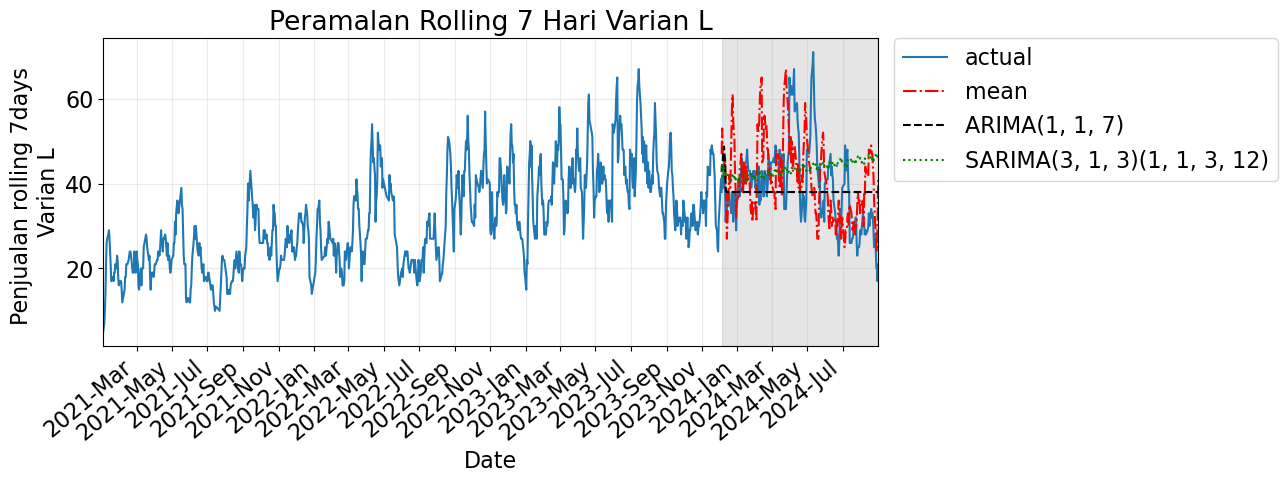

In [68]:
start_idx = 0  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"])
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian L")
ax.set_title("Peramalan Rolling 7 Hari Varian L")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_mean"], "r-.", label="mean")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 7)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(3, 1, 3)(1, 1, 3, 12)")

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

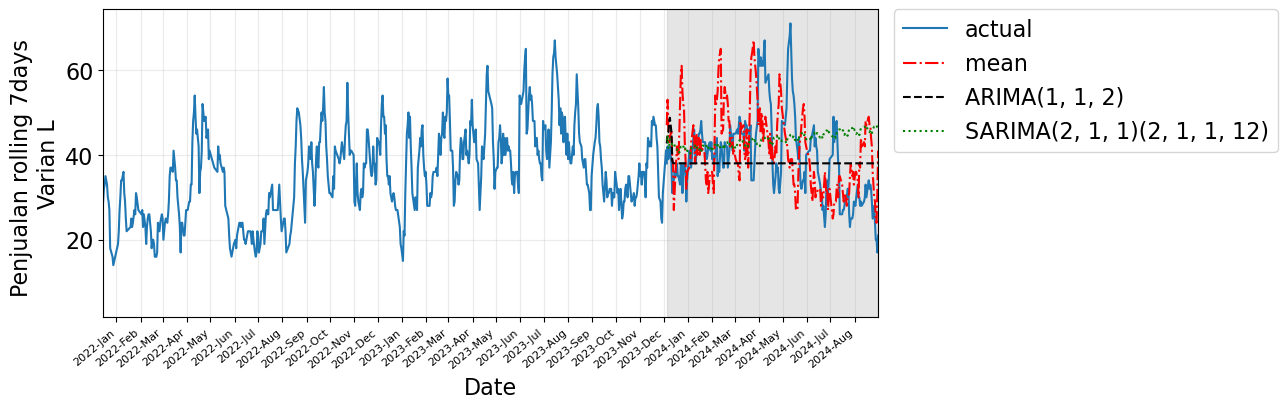

In [51]:
start_idx = 270  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"])
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian L")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_mean"], "r-.", label="mean")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 2)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(2, 1, 1)(2, 1, 1, 12)")
(1, 1, 1, 1)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi

In [52]:
mae_mean = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_mean"])
mae_arima          = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"])
mae_sarima         = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"])

print(f"MAE mean   : {mae_mean}")
print(f"MAE ARIMA  : {mae_arima}")
print(f"MAE SARIMA : {mae_sarima}")

MAE mean   : 9.61214953271028
MAE ARIMA  : 7.450616812622244
MAE SARIMA : 8.558247041244723


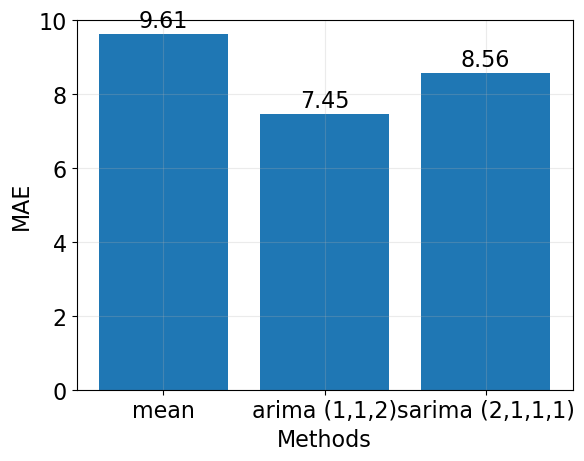

In [53]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (1,1,2)", "sarima (2,1,1,1)"]
y_array = [mae_mean, mae_arima, mae_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 10])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [54]:
mse_mean  = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_mean"])
mse_arima  = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"])
mse_sarima = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE arima: {mse_arima}")
print(f"MSE sarima: {mse_sarima}")

MSE mean: 143.97663551401868
MSE arima: 93.83399609466724
MSE sarima: 122.18296756893838


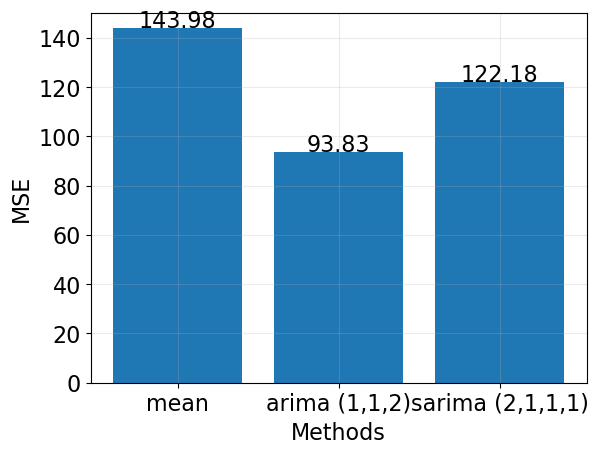

In [55]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (1,1,2)", "sarima (2,1,1,1)"]
y_array = [mse_mean, mse_arima, mse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 150])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [56]:
rmse_mean= np.sqrt(mse_mean)
rmse_arima          = np.sqrt(mse_arima)
rmse_sarima         = np.sqrt(mse_sarima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE arima: {rmse_arima}")
print(f"RMSE sarima: {rmse_sarima}")

RMSE mean: 11.999026440258337
RMSE arima: 9.68679493406706
RMSE sarima: 11.053640466784614


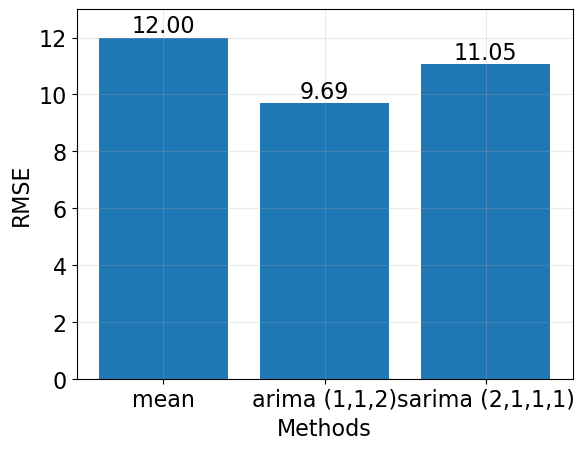

In [57]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (1,1,2)", "sarima (2,1,1,1)"]
y_array = [rmse_mean, rmse_arima, rmse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 13])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [58]:
mape_mean = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_mean"]) * 100 
mape_arima          = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"]) * 100
mape_sarima         = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"]) * 100

print(f"MAPE mean          : {mape_mean:5.2f}%")
print(f"         MAPE ARIMA: {mape_arima:5.2f}%")
print(f"        MAPE SARIMA: {mape_sarima:5.2f}%")

MAPE mean          : 25.23%
         MAPE ARIMA: 19.65%
        MAPE SARIMA: 25.70%


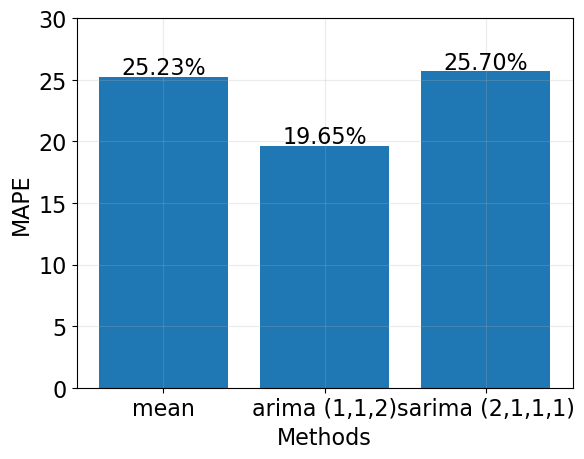

In [59]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (1,1,2)", "sarima (2,1,1,1)"]
y_array = [mape_mean, mape_arima, mape_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 30])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

In [60]:
naive = np.abs(np.diff(df_train["rolling_7days"])).mean()

mase_mean = mae_mean / naive
mase_arima = mae_arima / naive
mase_sarima  = mae_sarima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE arima: {mase_arima}")
print(f"MASE sarima: {mase_sarima}")

MASE mean: 3.454871928002769
MASE arima: 2.677957389721968
MASE sarima: 3.0760702749255024


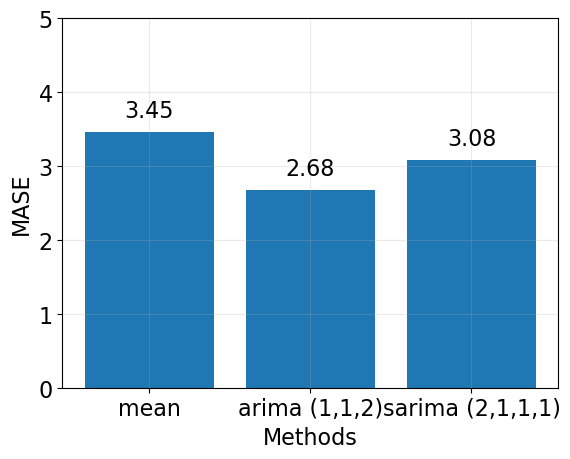

In [61]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (1,1,2)", "sarima (2,1,1,1)"]
y_array = [mase_mean, mase_arima, mase_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)